# Bike trip duration prediction

This notebook shows how to predict Bike trip duration using SparkML's Random Forest Regression. 

This notebook is intended to run on remote. 

### Steps
Using Spark,

1. It reads the table nyc-citi-bike from the BigQuery public datasets
2. It parses process the dataset to choose features and train the ML model (fits the regression model) to predict a target value.

   __Features__: month day hour start_station_name distance_lat distance_lon
   __Target__: tripduration_minutes
3. It evaluates and plot the results.
Details of the dataset
Thanks to NYC Open Data, which makes public data generated by city agencies available for public use, and Citi Bike, over 150 GB of data in 5 open datasets into Google BigQuery Public Datasets was incorporated, including:

Over 8 million 311 service requests since 2012 (updated daily)
Over a million motor vehicle collisions since 2012 (updated regularly)
Citi Bike stations and 30 million trips since 2013 (updated regularly)
Over 1 billion Yellow and Green Taxi rides since 2009 (updated regularly)
Over 600,000 trees surveyed decennially in 1995, 2005, and 2015
Read more about it on Reto Meier's Investigating New York City Public Datasets with BigQuery blogpost.

In [1]:
#### Import dependencies
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, dayofmonth, hour, minute, abs

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder \
    .appName("Bike trip duration prediction") \
    .enableHiveSupport() \
    .getOrCreate()

24/06/09 13:41:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
raw_dataset = spark.read.format('bigquery') \
    .option('project','bigquery-public-data') \
    .option('table','new_york_citibike.citibike_trips') \
    .load()

### Pre-process dataset / filter values


In [4]:
#### Filters
filters = [
"tripduration IS NOT NULL",
"starttime IS NOT NULL",
"start_station_latitude IS NOT NULL",
"start_station_longitude IS NOT NULL",
"end_station_latitude IS NOT NULL",
"end_station_longitude IS NOT NULL"
]
filters = " AND ".join(filters)
filtered_dataset = raw_dataset.filter(filters)

### Process dataset to create features

In [5]:
#### Define columns
label_column = 'tripduration_minutes'
columns = ['month', 'day', 'hour','start_station_name','distance_lat','distance_lon'] + [label_column]


#### Use tripsduration in minutes instead of seconds
filtered_dataset = filtered_dataset.withColumn("tripduration_minutes", col("tripduration")/60)
filtered_dataset = filtered_dataset.drop("tripduration")


#### Break starttime
filtered_dataset = filtered_dataset.withColumn("month", month(col("starttime")))
filtered_dataset = filtered_dataset.withColumn("day", dayofmonth(col("starttime")))
filtered_dataset = filtered_dataset.withColumn("hour", hour(col("starttime")))
filtered_dataset = filtered_dataset.withColumn("minute", minute(col("starttime")))


#### Calculate distances
filtered_dataset = filtered_dataset.withColumn("distance_lat", abs(abs(col("start_station_latitude")) - abs(col("end_station_latitude"))))
filtered_dataset = filtered_dataset.withColumn("distance_lon", abs(abs(col("start_station_longitude")) - abs(col("end_station_longitude"))))
filtered_dataset = filtered_dataset.drop(*["start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"])


#### Remove trips which ended in the same location it started
filtered_dataset = filtered_dataset.filter("distance_lat > 1 AND distance_lon > 1")


#### Select only relevant columns
sub_dataset = filtered_dataset.select(*columns)


#### Select only top stations
count_rider_per_station = sub_dataset.groupBy("start_station_name").count().sort(col("count").desc())
top_stations=count_rider_per_station.select("start_station_name").limit(30).rdd.map(lambda x: x[0]).collect()
sub_dataset = sub_dataset.filter(col("start_station_name").isin(top_stations))
sub_dataset.count()

97

### Transform features to LIBSVM format


In [6]:
categorical_columns = ['start_station_name']
feature_columns = ['month', 'day', 'hour','indexed_start_station_name','distance_lat','distance_lon']
#### Index categorical columns
indexers = [StringIndexer(inputCol=column, outputCol="indexed_" + column).fit(sub_dataset) for column in categorical_columns]
pipeline = Pipeline(stages=indexers)
indexed_dataset = pipeline.fit(sub_dataset).transform(sub_dataset)
indexed_dataset = indexed_dataset.drop(*categorical_columns)
indexed_dataset.show(5,20)

+-----+---+----+-----------------+-----------------+--------------------+--------------------------+
|month|day|hour|     distance_lat|     distance_lon|tripduration_minutes|indexed_start_station_name|
+-----+---+----+-----------------+-----------------+--------------------+--------------------------+
|   10|  1|   9|       40.7272235|       74.0337589|                 2.4|                       0.0|
|    9| 24|  16|      40.70569254|      74.01677685|             2168.85|                      17.0|
|    6| 13|  19|      40.70122128|      74.01234218|   282.1666666666667|                      27.0|
|    5|  2|  17|      40.76087502|      74.00277668|   9.116666666666667|                       2.0|
|    5|  2|   7|40.75898481399634|73.99379968643188|                 2.6|                       5.0|
+-----+---+----+-----------------+-----------------+--------------------+--------------------------+
only showing top 5 rows



In [7]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dataset = assembler.transform(indexed_dataset)

dataset = dataset.select(label_column,'features')
dataset = dataset.withColumnRenamed(label_column,'label')

dataset.show(5,20)

+-----------------+--------------------+
|            label|            features|
+-----------------+--------------------+
|              2.4|[10.0,1.0,9.0,0.0...|
|          2168.85|[9.0,24.0,16.0,17...|
|282.1666666666667|[6.0,13.0,19.0,27...|
|9.116666666666667|[5.0,2.0,17.0,2.0...|
|              2.6|[5.0,2.0,7.0,5.0,...|
+-----------------+--------------------+
only showing top 5 rows



### Train/Fit the model

In [8]:
(trainingData, testData) = dataset.randomSplit([0.8, 0.2])

rf = RandomForestRegressor(featuresCol="features")

pipeline = Pipeline(stages=[rf])

# Train model
model = pipeline.fit(trainingData)

rfModel = model.stages[0]
print(rfModel)

RandomForestRegressionModel: uid=RandomForestRegressor_f81010dcdf52, numTrees=20, numFeatures=6


### Evaluate the model

In [9]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 2267.373993055555| 842.2833333333333|[4.0,17.0,10.0,19...|
| 573.2433425355774|3.6666666666666665|[6.0,27.0,14.0,22...|
|1486.6540565650237| 4.316666666666666|[3.0,9.0,18.0,8.0...|
|472.49674090256656| 70.36666666666666|[9.0,16.0,12.0,2....|
|14.470246547895888|2.7666666666666666|[10.0,2.0,14.0,0....|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 1656.43


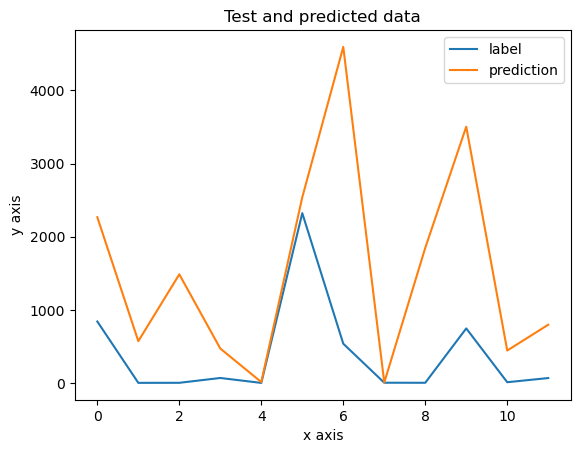

In [10]:
#### Plot predictions against target
x = range(0, predictions.count())
y_pred=predictions.select("prediction").collect()
y_target=predictions.select("label").collect()
 
plt.plot(x, y_target, label="label")
plt.plot(x, y_pred, label="prediction")
plt.title("Test and predicted data")

plt.xlabel('x axis')
plt.ylabel('y axis')

plt.legend(loc='best',fancybox=True, shadow=False)
plt.show()